# Functional Data Analysis with Monovariate Prediction
This notebook demonstrates the process of conducting a functional data analysis with a focus on monovariate prediction. It outlines the goal of the notebook, the dataset being used, and the main steps that will be taken.

## Setting Up the Environment
The following cells set up the environment by loading necessary libraries and defining the path to the simulation file.

In [1]:
# @__DIR__ is the directory of the current file
# We need to go up to the parent directory to find the project root
project_root = dirname(dirname(@__DIR__))


include(joinpath(project_root, "setup", "init_env.jl"))
set_R_lib_path(project_root)

  Activating project at `c:\Users\User\Documents\repos\TESI\tesi_data\progetto_s_on_f.md\b_spline\functional-data-regression-mip`


## Load Data and Run R Simulation
Here we load the data required for the simulation and run the R simulation script to prepare the data for analysis.

**NOTICE** -> The seed should be the same for both the training and the test datasets, otherwise the data distribution will be different. 
This is very important specifically in the "Paper simulation" where the predictors shape depends on the coefficients a1,...f3 extracted from Uniform and Normal distributions.  

In [ ]:
simulation_name = "paper"
simulation_settings_file = "default"
predictors= 6
basis_functions = 6
measurements = 150
observations_train = 300
observations_test = 100
phi = 10^-4
lambda = 10^-6

BigM = ones(predictors) .*  1000.0
BigM_ =  ones(predictors) .* - 1000.0;


In [4]:
include(joinpath(project_root,"simulations", "simulation.jl"))

params_train = (
    observations = 200,
    measurements = measurements,
    basis_functions = basis_functions,
    seed = 1,
    phi = phi
)

params_test = (
    observations = 200,
    measurements = measurements,
    basis_functions = basis_functions,
    seed = 22,
    phi = phi
)

# Note: Use ... to unpack NamedTuple into keyword arguments
output = load_simulation_gertheiss(simulation_name, simulation_settings_file, project_root; params_train...)

output_test = load_simulation_gertheiss(simulation_name, simulation_settings_file, project_root; params_test...)


# Grab the outputs from the R script

predictors = Int(output[:predictors])
true_predictors = output[:true_predictors]
intercept = output[:intercept]
observations = Int(output[:observations])

# betas and basis
beta_matrix  = output[:B]
basis_objs   = output[:basis_objs]
basis_values = output[:basis_values]
time_domains = output[:time_domains]

# matrixes 
U = output[:U]
X = output[:X]
Y = output[:Y]
Z = output[:Z]
J = output[:J]
W = output[:W]


X_test = output_test[:X]
Y_test = output_test[:Y]
Z_test = output_test[:Z]
J_test = output_test[:J]
W_test = output_test[:W]



# remove the first element of each row of Z
Z = Z[:, 2:end]

Z_reshaped = zeros(observations, predictors, basis_functions)
# For each observation
for i in 1:observations
  # For each predictor
  for j in 1:predictors
    # Assign the corresponding elements from Z to Z_reshaped
    # Skip the first element in each row by adding 1 to the start and end indices
    start_index = (j - 1) * basis_functions + 1
    end_index = min(j * basis_functions, length(Z[i,:]))
    Z_reshaped[i, j, :] = Z[i, start_index:end_index]
  end
end
Z = Z_reshaped

$predictors
[1] 6

$observations
[1] 200

$measurements
[1] 150

$basis_functions
[1] 6

$intercept
[1] 0

$norder
[1] 4

$mu_funcs
$mu_funcs[[1]]
function(t, args) {
    cos(2 * pi * (t - args$a1)) + args$a2
  }

$mu_funcs[[2]]
function(t, args) {
    args$b1 * sin(pi * t) + args$b2
  }

$mu_funcs[[3]]
function(t, args) {
    args$c1 * t^3 + args$c2 * t^2 + args$c3 * t
  }

$mu_funcs[[4]]
function(t, args) {
    sin(2 * (t - args$d1)) + args$d2 * t
  }

$mu_funcs[[5]]
function(t, args) {
    args$e1 * cos(2 * t) + args$e2 * t
  }

$mu_funcs[[6]]
function(t, args) {
    args$f1 * exp(-t / 3) + args$f2 * t + args$f3
  }


$beta_funcs
$beta_funcs[[1]]
function(t) {
    sin(t)
  }

$beta_funcs[[2]]
function(t) {
    sin(2 * t)
  }

$beta_funcs[[3]]
function(t) {
    if (c_val == 0) {
      rep(0, length(t))
    } else {
      -c_val * t^2
    }
  }

$beta_funcs[[4]]
function(t) {
    sin(2 * t)
  }

$beta_funcs[[5]]
function(t) {
    if (c_val == 0) {
      rep(0, length(t))
    } else {


base64 binary data: G1szM20bWzFt4pSMIBtbMjJtG1szOW0bWzMzbRtbMW1XYXJuaW5nOiAbWzIybRtbMzltUkNhbGwuamw6IENhcmljYW1lbnRvIGRlbCBwYWNjaGV0dG8gcmljaGllc3RvOiBzcGxpbmVzChtbMzNtG1sxbeKUgiAbWzIybRtbMzltQ2FyaWNhbWVudG8gZGVsIHBhY2NoZXR0byByaWNoaWVzdG86IGZkcwobWzMzbRtbMW3ilIIgG1syMm0bWzM5bUNhcmljYW1lbnRvIGRlbCBwYWNjaGV0dG8gcmljaGllc3RvOiByYWluYm93ChtbMzNtG1sxbeKUgiAbWzIybRtbMzltQ2FyaWNhbWVudG8gZGVsIHBhY2NoZXR0byByaWNoaWVzdG86IHBjYVBQChtbMzNtG1sxbeKUgiAbWzIybRtbMzltQ2FyaWNhbWVudG8gZGVsIHBhY2NoZXR0byByaWNoaWVzdG86IFJDdXJsChtbMzNtG1sxbeKUgiAbWzIybRtbMzltQ2FyaWNhbWVudG8gZGVsIHBhY2NoZXR0byByaWNoaWVzdG86IGRlU29sdmUKG1szM20bWzFt4pSCIBtbMjJtG1szOW0KG1szM20bWzFt4pSCIBtbMjJtG1szOW1DYXJpY2FtZW50byBwYWNjaGV0dG86ICdmZGEnChtbMzNtG1sxbeKUgiAbWzIybRtbMzltChtbMzNtG1sxbeKUgiAbWzIybRtbMzltSWwgc2VndWVudGUgb2dnZXR0byDoIG1hc2NoZXJhdG8gZGEgJ3BhY2thZ2U6Z3JhcGhpY3MnOgobWzMzbRtbMW3ilIIgG1syMm0bWzM5bQobWzMzbRtbMW3ilIIgG1syMm0bWzM5bSAgICBtYXRwbG90ChtbMzNtG1sxbeKUgiAbWzIybRtbMzltChtbMzNtG1sxbeKUgiAbWzIybRtbMzltaGVyZSgpIHN0YXJ0

[1] 1e-04
$predictors
[1] 6

$observations
[1] 200

$measurements
[1] 150

$basis_functions
[1] 6

$intercept
[1] 0

$norder
[1] 4

$mu_funcs
$mu_funcs[[1]]
function(t, args) {
    cos(2 * pi * (t - args$a1)) + args$a2
  }

$mu_funcs[[2]]
function(t, args) {
    args$b1 * sin(pi * t) + args$b2
  }

$mu_funcs[[3]]
function(t, args) {
    args$c1 * t^3 + args$c2 * t^2 + args$c3 * t
  }

$mu_funcs[[4]]
function(t, args) {
    sin(2 * (t - args$d1)) + args$d2 * t
  }

$mu_funcs[[5]]
function(t, args) {
    args$e1 * cos(2 * t) + args$e2 * t
  }

$mu_funcs[[6]]
function(t, args) {
    args$f1 * exp(-t / 3) + args$f2 * t + args$f3
  }


$beta_funcs
$beta_funcs[[1]]
function(t) {
    sin(t)
  }

$beta_funcs[[2]]
function(t) {
    sin(2 * t)
  }

$beta_funcs[[3]]
function(t) {
    if (c_val == 0) {
      rep(0, length(t))
    } else {
      -c_val * t^2
    }
  }

$beta_funcs[[4]]
function(t) {
    sin(2 * t)
  }

$beta_funcs[[5]]
function(t) {
    if (c_val == 0) {
      rep(0, length(t))
   

200×6×6 Array{Float64, 3}:
[:, :, 1] =
 2.73761   1.3217     2.42033   0.166476   -6.15037   5.09658
 2.94294   1.3917     2.64715   0.648445   -6.11012   3.26297
 3.19663   1.01392    2.5553    0.578808   -7.29366   7.09473
 4.40772   1.10207    3.33275   0.24474    -5.4329    8.51186
 4.04396   1.00743    1.88206  -0.0131012  -6.45862  10.0119
 3.91376   0.70032    4.0894   -0.30835    -6.23703   4.90131
 2.98582   0.547799   2.46282  -0.34504    -7.26936   6.58808
 3.18106   0.586923   2.58731  -0.135087   -6.31136   1.03951
 3.19193   1.31275    3.74227  -0.377515   -6.61822   4.22692
 2.72069   0.401503   2.34025   0.734059   -7.33626   9.13116
 4.36824  -0.0846515  4.25774   0.50922    -7.60054   5.38239
 3.05011   1.3699     3.72109   0.328463   -5.57095   6.76565
 4.24123   0.287868   2.94579   0.431073   -8.20756   6.77619
 ⋮                                                    ⋮
 3.01238   1.08626    3.23044  -0.195806   -6.47658   2.93916
 3.87456   1.41661    3.42512   0.4551

In [5]:
model_name = "l0_gertheiss"
model_file_path = joinpath(project_root, "src", "Julia","models", model_name *".jl")

include(model_file_path)

beta_matrix_max_values = maximum(beta_matrix, dims = 2)
beta_matrix_min_values = minimum(beta_matrix, dims = 2)


# create a zero matrix from beta_star dimensions
initial_betas = beta_matrix
to_predict = sum(true_predictors)
beta_star, alpha_star, groups = mip_functional_regression(Y, Z, BigM,BigM_; intercept = output[:intercept] != 0, group_limit= to_predict, initial_beta = initial_betas,initial_group=to_predict,lambda);

project_root = dirname( dirname(@__DIR__))
plot_file_path = joinpath(project_root, "src", "Julia","utils", "plot.jl")

include(plot_file_path)

output_folder= joinpath(project_root, "outputs", "plots", simulation_name)

beta_point_values = output[:beta_point_values]





Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Set parameter TimeLimit to value 1800
Set parameter Presolve to value 0
Set parameter Heuristics to value 0
Set parameter MIPGap to value 0
Set parameter MIPFocus to value 1
Set parameter NumericFocus to value 3
Set parameter NonConvex to value 2
Set parameter OptimalityTol to value 1e-09
Set parameter IntFeasTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Set parameter TimeLimit to value 1800
Set parameter TimeLimit to value 1800
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 145 rows, 78 columns and 294 nonzeros
Model fingerprint: 0x06ee1aa7
Model has 666 quadratic objective terms
Variable types: 72

6×150 Matrix{Float64}:
 0.0  0.00671136  0.0134224  0.0201329  …  0.834143  0.837826  0.841471
 0.0  0.0140559   0.028109   0.0421565     0.879738  0.872968  0.866025
 0.0  0.0         0.0        0.0           0.0       0.0       0.0
 0.0  0.0140559   0.028109   0.0421565     0.879738  0.872968  0.866025
 0.0  0.0         0.0        0.0           0.0       0.0       0.0
 0.0  0.0         0.0        0.0        …  0.0       0.0       0.0

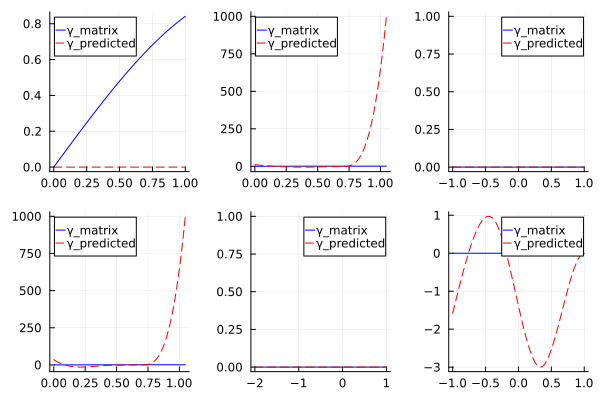

"c:\\Users\\User\\Documents\\repos\\TESI\\tesi_data\\progetto_s_on_f.md\\b_spline\\functional-data-regression-mip\\outputs\\plots\\paper\\combined.png"

In [6]:
plot_combined_predicted_curve(beta_point_values, beta_star,basis_values, time_domains,output_folder, true)

In [7]:
beta_matrix

6×6 Matrix{Float64}:
 5.30582e-6   0.1111    0.333325  0.629925  0.781476  0.841466
 0.000186225  0.232358  0.69762   1.06815   0.98308   0.865984
 0.0          0.0       0.0       0.0       0.0       0.0
 0.000186225  0.232358  0.69762   1.06815   0.98308   0.865984
 0.0          0.0       0.0       0.0       0.0       0.0
 0.0          0.0       0.0       0.0       0.0       0.0

In [8]:
beta_star

6×6 Matrix{Float64}:
  0.0       0.0      0.0       0.0       0.0     0.0
 11.1279    0.0     -8.96194   0.0       0.0  1000.0
  0.0       0.0      0.0       0.0       0.0     0.0
 35.3493  -30.0491   0.0       0.309534  0.0  1000.0
  0.0       0.0      0.0       0.0       0.0     0.0
 -1.5829    0.0      3.04735  -6.01138   0.0     0.0

In [9]:
using Statistics 
using LinearAlgebra

include(joinpath(project_root, "src", "Julia", "utils", "data_analysis.jl"))

performance_metrics = compute_metrics(Y, Z, beta_matrix, beta_matrix, alpha_star, groups, predictors)


Dict{String, Float64} with 7 entries:
  "RMSE_Coefficients"  => 0.0
  "ISE_Coefficients"   => 0.0
  "MSE_Predictions"    => 0.544935
  "R_squared"          => 0.747173
  "Adjusted_R_squared" => 0.749367
  "MSE_Coefficients"   => 0.0
  "RMSE_Predictions"   => 0.738197

In [ ]:
performance_metrics = compute_metrics(Y, Z, beta_matrix, beta_star, alpha_star, groups, predictors)


Dict{String, Float64} with 11 entries:
  "Functional_Correlation" => 0.853887
  "CDF_Distance"           => 0.233924
  "R_squared"              => 0.716665
  "RMSE_Predictions"       => 0.781467
  "RMSE_Coefficients"      => 235.642
  "Area_Between_Curves"    => 128.837
  "ISE_Coefficients"       => 1.99898e6
  "MSE_Predictions"        => 0.610691
  "Adjusted_R_squared"     => 0.707995
  "MSE_Coefficients"       => 55527.1
  "MAE_Predictions"        => 0.644187